In [ ]:
import numpy as np
import pandas as pd
import torch

from utils.ae_script import (
    prepare_data,
    create_dataset,
    combined_ae_training_loop,
    multimodal_ae_training_loop,
    generate_patient_embeddings,
    downstream_performance,
    interpret_model
)

from models.surv_mac import (
    VanillaMaskedAutoencoder,
    Surv_MAC
)

# save the patients_df
df = pd.read_csv('./data/msk_2024_fe_10.csv')

os_months_index = df.columns.get_loc("OS_MONTHS")

gene_mutations = df.iloc[:, :os_months_index]  # Exclude the first column (ID) and OS_MONTHS
data_labels = df.iloc[:, os_months_index:]  # Include only the OS_MONTHS column as labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 'highest_stage_recorded', 'CNS_BRAIN', 'LIVER', 'LUNG', 'Regional', 'Distant', 'CANCER_TYPE_BREAST', 'CANCER_TYPE_COLON', 'CANCER_TYPE_LUNG', 'CANCER_TYPE_PANCREAS', 'CANCER_TYPE_PROSTATE'
cd_bin = ['highest_stage_recorded', 'CNS_BRAIN', 'LIVER', 'LUNG', 'Regional', 'Distant', 'CANCER_TYPE_BREAST', 'CANCER_TYPE_COLON', 'CANCER_TYPE_LUNG', 'CANCER_TYPE_PANCREAS', 'CANCER_TYPE_PROSTATE', "AGE_GE_65", "TMB_GE_10", "FRACTION_GENOME_ALTERED_GE_0.2"]
GMP, CD_BINARY, patient_ids, all_columns, fulldata_set = prepare_data(gene_mutations, data_labels, cd_bin=cd_bin, device=device)
print(f"Gene Mutation Profile: {GMP.shape}")
print(f"CD Binary: {CD_BINARY.shape}")
print(f"Overall Features: {GMP.shape[1] + CD_BINARY.shape[1]}")
print(f"Full Data: {fulldata_set.shape}")

2025-05-13 09:22:42.040410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747142562.157447   21157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747142562.191915   21157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 09:22:42.533429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cuda
Gene Mutation Profile: (22284, 1165)
CD Binary: (22284, 14)
Overall Features: 1179
Full Data: torch.Size([22284, 1179])


In [2]:
num_positives = np.sum(GMP, axis=0)  # Count the number of positive mutations for each gene
num_negatives = GMP.shape[0] - num_positives  # Count the number of negative mutations for each gene
pos_weight = num_negatives / (num_positives + 1e-6)  # Avoid division by zero
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

combined_data = np.hstack([GMP, CD_BINARY])
num_positives_whole = np.sum(combined_data, axis=0)  # Count the number of positive mutations for each gene
num_negatives_whole = combined_data.shape[0] - num_positives_whole  # Count the number of negative mutations for each gene
pos_weight_whole = num_negatives_whole / (num_positives_whole + 1e-6)  # Avoid division by zero
pos_weight_whole = torch.tensor(pos_weight_whole, dtype=torch.float32)

In [3]:
# parameters
batch_size = 1024

train_loader, val_loader = create_dataset(
    GMP, CD_BINARY, 
    batch_size=batch_size, 
    train_split=0.85
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Validation Loader: {len(val_loader)} batches")

Train Loader: 19 batches
Validation Loader: 4 batches


In [45]:
# model parameters
ae_type = 'surv_mac' # 'vanilla' or 'surv_mac'

intra_gmp=('res', 'res', 'se')
intra_cd=('se')

fusion_method = 'bi_film'  # 'gated', 'film', 'bilinear', 'moe', 'crossattn', 'bi_film'

baseline = False  # Whether to use a baseline for the MMA
expansion = 1  # Expansion factor for the model
dropout=0.2

multiples = 1
latent_dim = int(256 // multiples)
hidden_dim = int(512 // multiples)
proj_dim = int(128 // multiples)
                       
training_method = 'contrastive'  # Loss function for autoencoder (can be 'normal', 'masked', or 'contrastive')
mask_ratio = 0.3  # Ratio of input features to mask (for masked autoencoder)
beta = 0.3
num_epochs = 80
# 1e-2, 5e-3, 1e-3, 5e-4, 1e-4
learning_rate = 5e-4
l2_lambda = 1e-4

if ae_type == 'surv_mac':
    # Define the model type for MMA
    model_type = 'split'  # Model type for MMA (can be 'split', 'combined', or 'separate')
else:
    model_type = 'combined'
    
raw_loss = False
pos_weight = pos_weight.to(device)  # Move pos_weight to the same device as the model
pos_weight_whole = pos_weight_whole.to(device)  # Move pos_weight to the same device as the model
combined_recon = True if model_type == "combined" else False

# model_path = f"./model_checkpoints/{ae_type}_{backbone}_{cross_attn_layers}_{shared_attn}_{baseline}_{combined_recon}_{training_method}_{mask_ratio}_{beta}.pt"
model_path = None
interpret = True
clustering = True

# Initialize the model
if ae_type == 'vanilla':
    model = VanillaMaskedAutoencoder(
        num_genes=GMP.shape[1],
        num_cd_fields=CD_BINARY.shape[1],
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        proj_dim=proj_dim,
    ).to(device)
    
elif ae_type == 'surv_mac':
    model = Surv_MAC(
        num_genes=GMP.shape[1],
        num_cd_fields=CD_BINARY.shape[1],
        intra_gmp=intra_gmp,
        intra_cd=intra_cd,
        fusion_method=fusion_method,
        baseline=baseline,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        proj_dim=proj_dim,
        dropout=dropout,
        expansion_factor=expansion).to(device)

In [46]:
if model_type == "split":
    train_losses, val_losses, best_model =  multimodal_ae_training_loop(model, 
                                                                        train_loader, 
                                                                        val_loader, 
                                                                        num_epochs=num_epochs, 
                                                                        learning_rate=learning_rate, 
                                                                        pos_weight=pos_weight if not raw_loss else None,
                                                                        device=device, 
                                                                        method=training_method, 
                                                                        l2_lambda=l2_lambda, 
                                                                        mask_ratio=mask_ratio,
                                                                        alpha=1,
                                                                        beta=0.3,
                                                                        gamma=1,
                                                                        verbose=True,
                                                                        save_path=model_path)
elif model_type == "combined":
    train_losses, val_losses, best_model =  combined_ae_training_loop(model, 
                                                                        train_loader, 
                                                                        val_loader, 
                                                                        num_epochs=num_epochs, 
                                                                        learning_rate=learning_rate,
                                                                        pos_weight=pos_weight_whole if not raw_loss else None,
                                                                        device=device, 
                                                                        method=training_method,
                                                                        l2_lambda=l2_lambda,
                                                                        mask_ratio=mask_ratio,
                                                                        beta=0.2,
                                                                        verbose=True,
                                                                        save_path=model_path)


Epoch   0: train 3.8447  val 3.3593
Epoch   5: train 2.9294  val 2.9803
Epoch  10: train 2.7840  val 2.9141
Epoch  15: train 2.6807  val 2.9585
Epoch  20: train 2.6207  val 2.9034
Epoch  25: train 2.5705  val 2.9207
Epoch  30: train 2.5200  val 3.0067
Epoch  35: train 2.4854  val 2.9428
Epoch  40: train 2.4670  val 2.9387
Epoch  45: train 2.4404  val 2.9514
Epoch  50: train 2.4208  val 3.0478
Epoch  55: train 2.4019  val 3.0082
Epoch  60: train 2.3880  val 3.0858
Epoch  65: train 2.3742  val 3.0766
Epoch  70: train 2.3561  val 2.9482
Epoch  75: train 2.3395  val 3.0027


In [ ]:
import matplotlib.pyplot as plt

# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [48]:
latent_rep, latent_df = generate_patient_embeddings(
    model = model,
    gmp = GMP,
    cd_binary = CD_BINARY,
    best_model = best_model,
    device = device,
    latent_dim = latent_dim,
    patient_ids = patient_ids,
    save_path = None,
    dataloader_path= None
)

Input dimension for downstream task: 256
Training on 15598 samples, validating on 3343 samples, testing on 3343 samples.
Using model: MLP with input dimension: 256
Starting training for 100 epochs...
New best model found at epoch 1 with validation loss: 7.4027 and C-Index: 0.6663
New best model found at epoch 2 with validation loss: 7.3304 and C-Index: 0.7002
New best model found at epoch 3 with validation loss: 7.2815 and C-Index: 0.7125
New best model found at epoch 4 with validation loss: 7.2508 and C-Index: 0.7178
New best model found at epoch 5 with validation loss: 7.2309 and C-Index: 0.7205
New best model found at epoch 6 with validation loss: 7.2159 and C-Index: 0.7228
New best model found at epoch 7 with validation loss: 7.2038 and C-Index: 0.7252
New best model found at epoch 8 with validation loss: 7.1943 and C-Index: 0.7275
New best model found at epoch 9 with validation loss: 7.1869 and C-Index: 0.7293
Epoch 10/100, Train Loss: 8.7621, Val Loss: 7.1815, C-Index: 0.7307
New

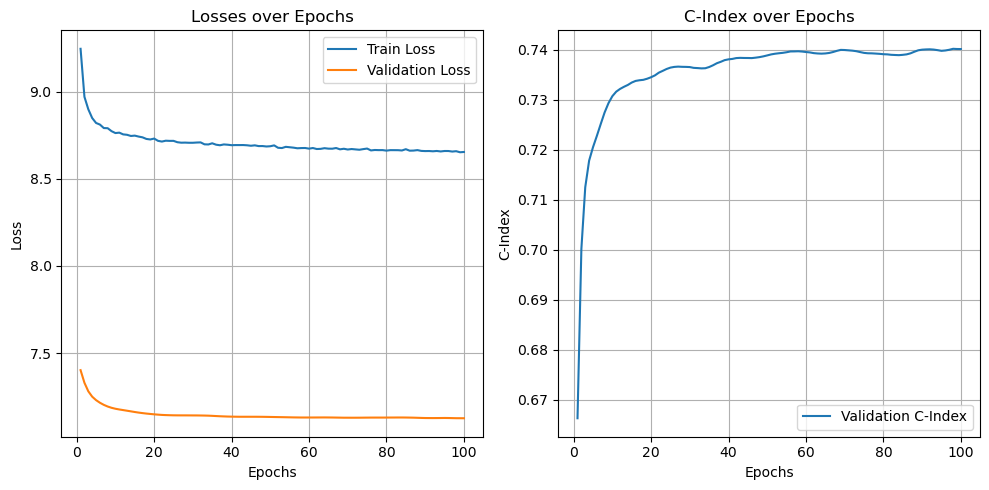

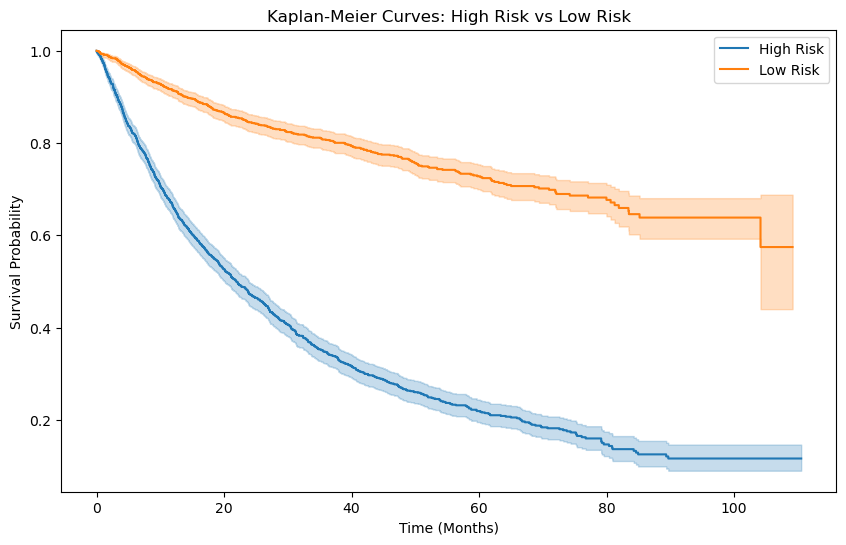

Log-rank test p-value: 3.563056741610032e-174
Test Loss: 7.1547, Test c-index: 0.7403


In [49]:
y_os = data_labels['OS_MONTHS']
y_status = data_labels['OS_STATUS']
ds_batch_size = 3000
whole_dataset = True
input_dim = latent_df.shape[1]
print(f"Input dimension for downstream task: {input_dim}")
ds_model = 'MLP'
ds_epoch = 100
ds_lr = 1e-3
ds_l2_reg = 1e-4
verbose = True

train_losses, val_losses, val_c_indices, c_index_whole, ds_model, ds_best_model = downstream_performance(latent_df,
                                                                                                            y_os, 
                                                                                                            y_status,
                                                                                                            device,
                                                                                                            ds_batch_size,
                                                                                                            whole_dataset,
                                                                                                            ds_model,
                                                                                                            ds_epoch,
                                                                                                            input_dim,
                                                                                                            ds_lr,
                                                                                                            ds_l2_reg)

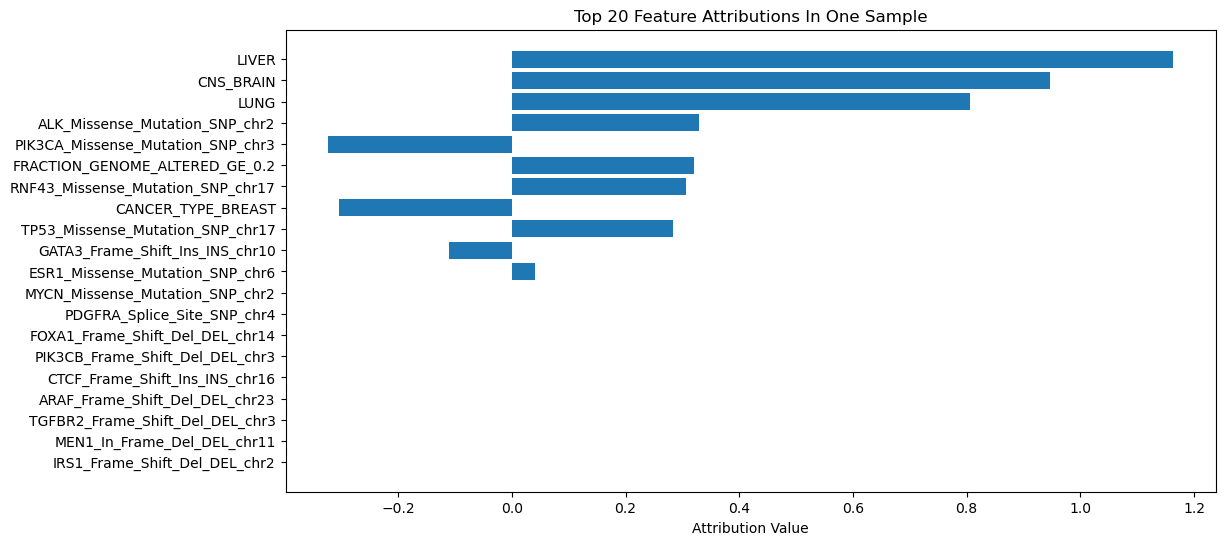

Convergence Delta: 0.030398418648696524


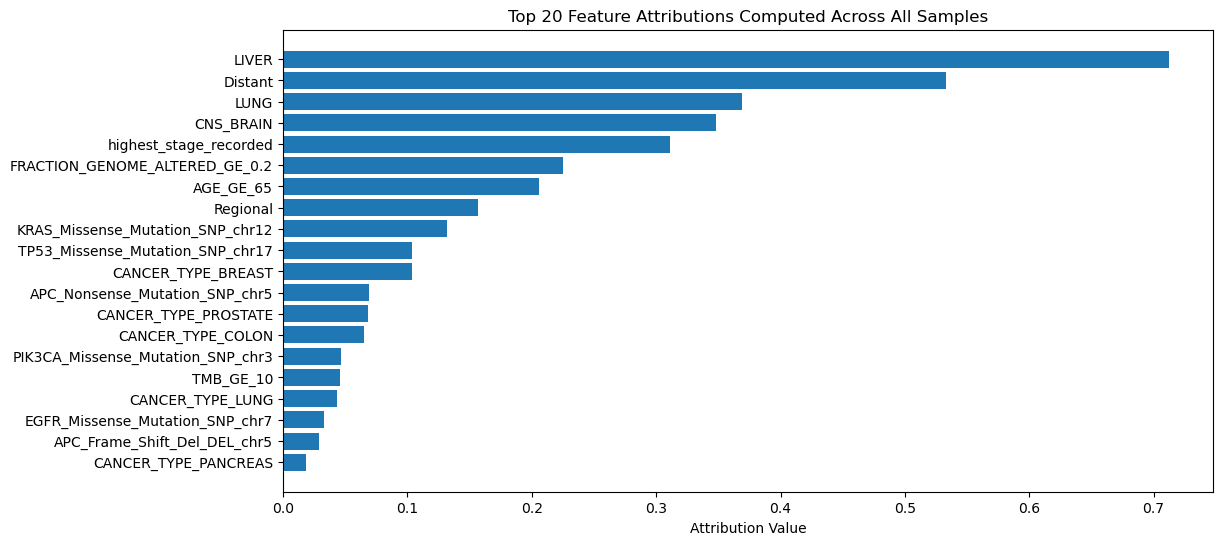

Convergence Delta: 0.030398418648696524


In [50]:
if interpret:
    interpret_model(ae_model=model,
                    ds_model=ds_model,
                    ae_best_model=best_model,
                    ds_best_model=ds_best_model,
                    ae_type="mm",
                    gmp_index=GMP.shape[1],
                    all_columns=all_columns,
                    X_test=fulldata_set,
                    verbose=False,
                    sample_size=1000,
                    device=device)

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


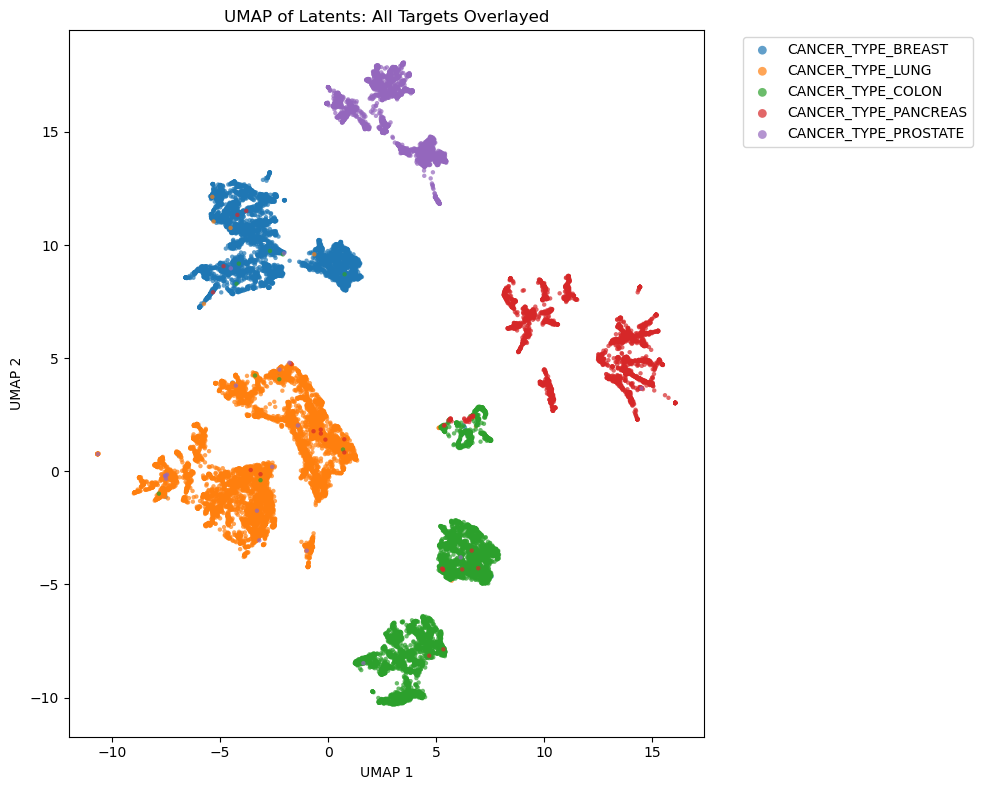

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


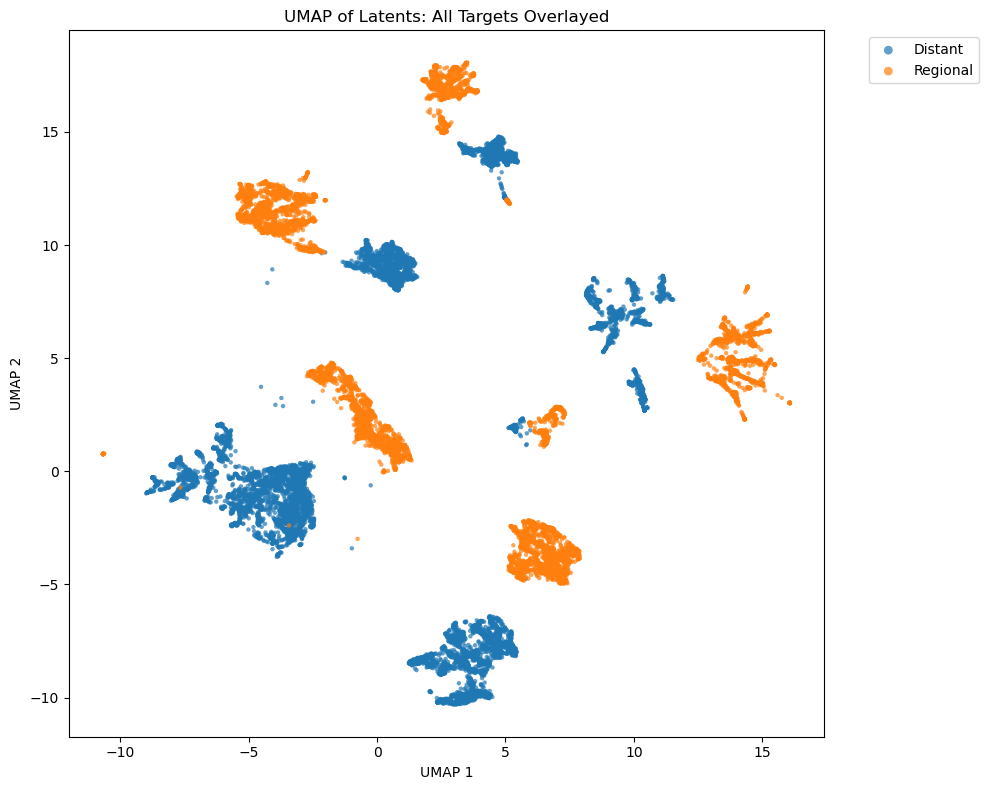

In [53]:
# targets = ['LIVER', 'Distant', 'highest_stage_recorded', 'CNS_BRAIN', 'LUNG', 'CANCER_TYPE_BREAST','CANCER_TYPE_LUNG','CANCER_TYPE_COLON','CANCER_TYPE_PANCREAS','CANCER_TYPE_PROSTATE', 'Regional', 'AGE_GE_65', 'TMB_GE_10', 'FRACTION_GENOME_ALTERED_GE_0.2']

cancer_types = ['CANCER_TYPE_BREAST','CANCER_TYPE_LUNG','CANCER_TYPE_COLON','CANCER_TYPE_PANCREAS','CANCER_TYPE_PROSTATE']
metastasis_spread = ["Distant", "Regional"]

import numpy as np
import matplotlib.pyplot as plt
import umap

def plot_umap_all_targets(latent_embeddings, y, target_names=None, save_path=None):
    """
    Plots one UMAP projection of latent_embeddings, overlaying all targets in different colors.
    
    Args:
      latent_embeddings (np.ndarray): [n_samples, latent_dim]
      y (np.ndarray): [n_samples, n_targets], e.g. binary indicators per target
      target_names (list of str]): optional names length n_targets
      save_path (str): optional path to save the figure (e.g. "umap_all_targets.png")
    """
    # Ensure numpy
    y_np = y if isinstance(y, np.ndarray) else y.numpy()
    n_targets = y_np.shape[1]

    # 1. Compute UMAP once
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_emb = reducer.fit_transform(latent_embeddings)

    # 2. Choose a qualitative colormap with enough distinct colors
    #    'tab10' has 10 colors; for more targets try 'tab20' or a custom palette
    cmap = plt.get_cmap('tab10')
    
    plt.figure(figsize=(10, 8))
    
    # 3. Plot each target's points
    for i in range(n_targets):
        mask = y_np[:, i] == 1     # or whatever criterion defines membership
        color = cmap(i % cmap.N)
        label = target_names[i] if target_names else f"Target {i}"
        
        plt.scatter(
            umap_emb[mask, 0],
            umap_emb[mask, 1],
            c=[color],
            label=label,
            s=10,
            alpha=0.7,
            edgecolors='none'
        )
    
    plt.title("UMAP of Latents: All Targets Overlayed")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


# Get highest stage recorded; convert to float32 for PyTorch
type_y = df[cancer_types].values.astype(np.float32)
spread_y = df[metastasis_spread].values.astype(np.float32)

if clustering:
    plot_umap_all_targets(
        latent_rep,
        type_y,
        cancer_types,
    )
    
    plot_umap_all_targets(
        latent_rep,
        spread_y,
        metastasis_spread,
    )